In [5]:
from pathlib import Path
import kagglehub

# Download latest version
path = kagglehub.dataset_download("changheonkim/iam-trocr")
path = Path(path)/"IAM"
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'iam-trocr' dataset.
Path to dataset files: /kaggle/input/iam-trocr/IAM


In [6]:

# Assuming 'path' variable holds the base directory from kagglehub.dataset_download
# If not, please replace 'path' with the correct directory string, e.g., '/content/IAM'
if 'path' in globals():
    print(f"Listing directories in: {path}")
    # Use a shell command to list only directories recursively, and sort them
    !ls {path/"image"}


Listing directories in: /kaggle/input/iam-trocr/IAM
c04-110-00.jpg	e06-070-02.jpg	 g07-000b-00.jpg  n02-157-05.jpg
c04-110-01.jpg	e06-070-03.jpg	 g07-000b-01.jpg  n02-157-06.jpg
c04-110-02.jpg	e06-070-04.jpg	 g07-000b-02.jpg  n02-157-07.jpg
c04-110-03.jpg	e06-070-05.jpg	 g07-000b-03.jpg  n02-157-08.jpg
c04-116-00.jpg	e06-070-06.jpg	 g07-000b-04.jpg  n03-038-00.jpg
c04-116-01.jpg	e06-070-07.jpg	 g07-000b-05.jpg  n03-038-01.jpg
c04-116-02.jpg	e06-070-08.jpg	 g07-000b-06.jpg  n03-038-02.jpg
c04-116-03.jpg	e06-070-09.jpg	 g07-000b-07.jpg  n03-038-03.jpg
c04-134-00.jpg	f04-032-00.jpg	 g07-000b-08.jpg  n03-038-04.jpg
c04-134-01.jpg	f04-032-01.jpg	 g07-000b-09.jpg  n03-038-05.jpg
c04-134-02.jpg	f04-032-02.jpg	 g07-079a-00.jpg  n03-038-06.jpg
c04-134-03.jpg	f04-032-03.jpg	 g07-079a-01.jpg  n03-064-00.jpg
c04-134-04.jpg	f04-032-04.jpg	 g07-079a-02.jpg  n03-064-01.jpg
c04-134-05.jpg	f04-032-05.jpg	 g07-079a-03.jpg  n03-064-02.jpg
c04-134-06.jpg	f04-032-06.jpg	 g07-079a-04.jpg  n03-064-03.jpg
c04

In [7]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
import torch

# Load the model
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-handwritten")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Loading weights:   0%|          | 0/360 [00:00<?, ?it/s]

VisionEncoderDecoderModel LOAD REPORT from: microsoft/trocr-small-handwritten
Key                         | Status  | 
----------------------------+---------+-
encoder.pooler.dense.bias   | MISSING | 
encoder.pooler.dense.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=384, out_features=1536, bias=True)
        

In [8]:
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, image_dir, annotation_file, processor):
        self.image_dir = image_dir
        self.processor = processor
        self.samples = []

        with open(annotation_file, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue

                image_name, text = line.split("\t")
                self.samples.append((image_name, text))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_name, text = self.samples[idx]

        image = Image.open(self.image_dir / image_name).convert("RGB")

        pixel_values = self.processor(
            images=image,
            return_tensors="pt"
        ).pixel_values.squeeze()

        labels = self.processor.tokenizer(
            text,
            padding="max_length",
            max_length=8,
            truncation=True,
            return_tensors="pt"
        ).input_ids.squeeze()

        return {
            "pixel_values": pixel_values,
            "labels": labels
        }


In [9]:
pip install git+https://github.com/haotian-liu/LLaVA.git

  Cloning https://github.com/haotian-liu/LLaVA.git to /tmp/pip-req-build-l9e20lqt
  Running command git clone --filter=blob:none --quiet https://github.com/haotian-liu/LLaVA.git /tmp/pip-req-build-l9e20lqt
  Resolved https://github.com/haotian-liu/LLaVA.git to commit c121f0432da27facab705978f83c4ada465e46fd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of llava to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement torch==2.1.2 (from llava) (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0, 2.9.0, 2.9.1, 2.10.0)
ERROR: No matching distribution found for torch==2.1.2


In [10]:
from transformers import LlavaProcessor, LlavaForConditionalGeneration

In [11]:
model_id = "llava-hf/llava-1.5-7b-hf"

In [12]:
from transformers import LlavaProcessor, LlavaForConditionalGeneration
from PIL import Image
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = LlavaProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
llava = LlavaForConditionalGeneration.from_pretrained(
    "llava-hf/llava-1.5-7b-hf",
    torch_dtype=torch.float16
).to(device)

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/686 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [23]:
from pathlib import Path

base = Path("/kaggle/input/iam-trocr/IAM/image")

images = list(base.rglob("*.png"))

print("Total imagens:", len(images))
print("Exemplo:", images[:5])

Total imagens: 0
Exemplo: []


Total imagens: 2915
Primeira imagem: /kaggle/input/iam-trocr/IAM/image/g01-019-06.jpg


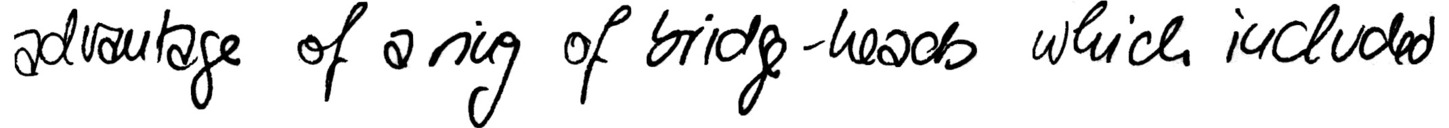

In [26]:
from pathlib import Path
from PIL import Image

base = Path("/kaggle/input/iam-trocr/IAM/image")

images = list(base.glob("*.jpg"))

print("Total imagens:", len(images))
print("Primeira imagem:", images[0])

image = Image.open(images[0]).convert("RGB")
image

In [ ]:
!pip install -U bitsandbytes>=0.46.1
!pip install -U transformers accelerate

In [31]:
from transformers import LlavaForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
)

model_llava = LlavaForConditionalGeneration.from_pretrained(
    "llava-hf/llava-1.5-7b-hf",
    quantization_config=bnb_config,
    device_map="auto"
)

processor_llava = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")

ImportError: Using `bitsandbytes` 4-bit quantization requires bitsandbytes: `pip install -U bitsandbytes>=0.46.1`